# Randomized Measurements for Multi-param Quantum Metrology

Sisi Zhou, Senrui Chen. arXiv: 2502.03536

use 'qiskit==2.0.0'

250506: Not using boostrap

250518: Changed reference state to non-stabilizer

Turns out there might be a bug -- I have not reparameterized to fidelity at every step.

250519: Use subsampling to estimate variance of variance!!!

In [ ]:
import numpy as np
from numpy import exp, sqrt, log, pi, cos, sin, abs, mod,arccos,array
import matplotlib.pyplot as plt
import qiskit
import random
import math
from copy import deepcopy
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Clifford
from qiskit.quantum_info import random_clifford
from qiskit_aer import AerSimulator
import numpy as np

In [ ]:
import sys
print(sys.executable)

In [71]:
qiskit.__version__


'2.0.0'

## Problem setup

In [72]:
n = 3
X = np.matrix([[0,1],[1,0]])
I = np.matrix([[1,0],[0,1]])
Xlist = []
vec0n = np.matrix([1]+[0]*((1<<n)-1)).T
vec1n = np.matrix([0]*((1<<n)-1) + [1]).T
vec_ghz = (vec0n + vec1n)/sqrt(2)
vec_ghzp = []
for i in range(n):
    mat_tmp = np.matrix([[1]])
    for j in range(i):
        mat_tmp = np.kron(I,mat_tmp)
    mat_tmp = np.kron(X,mat_tmp)
    for j in range(i+1,n):
        mat_tmp = np.kron(I,mat_tmp)
    # print(i)
    # print(mat_tmp)
    Xlist.append(mat_tmp)
    vec_ghzp.append(mat_tmp @ vec_ghz)
    


In [73]:
### Define reference state
### NEW: ADD OFFSET
offset = 0.025
g_const = 0.05 + offset
g_r = [g_const] * 3
vec_r = sqrt(1 - sum(g_r)) * vec_ghz + sum([sqrt(g_r[i]) * vec_ghzp[i]  for i in range(n)])
psi_r = Statevector(vec_r)

### Use for fidelity estimation in post-processing
ref_circuit = QuantumCircuit(n)
ref_circuit.initialize(psi_r)

### import ground truth
eps_list = [0.05,0.10,0.15,0.20]
f_ground_truth = {}
for eps in eps_list:
    g_t = [g_const + eps - offset] * 3
    vec_t = sqrt(1 - sum(g_t)) * vec_ghz + sum([sqrt(g_t[i]) * vec_ghzp[i]  for i in range(n)])
    f_ground_truth[eps] = abs(vec_t.H @ vec_r).item()**2
print(f_ground_truth)


# ==== Parameter definitions ====
np.random.seed(9527)
n = 3          # Number of qubits (you can customize this)
Nu = 100000         # Number of random Clifford gates
Ns = 10000      # Number of measurement shots per experiment
Nsub = 1        # If enable subsampling
sub_sampling = True

BS = 500 # Boostrap sample (Not exactly boostrap, as I decide to draw without replacement)
dpb = 5000 # data per batch


Nui = dpb // 5 # initial crude estimate
Nus = dpb # samples for each step of iteration
IterCap = 10 # 10 rounds of iteration for now

{0.05: 0.9927205246651916, 0.1: 0.9429891695339357, 0.15: 0.8541454509095749, 0.2: 0.7241369035372355}


## Data Processing (All in One)

In [74]:
# Some helper functions / definitions
ghz_circ = QuantumCircuit(n)
ghz_circ.h(0)
for k in range(1,n):
    ghz_circ.cx(0,k)

In [ ]:

print_batch = True

cs_res = {}
rm2_res = {}

# for eps in eps_list:
for eps in eps_list:
    # load_label = "250518_" + f"{eps:.{2}f}".removeprefix("0.") 
    load_label = "250518_" + f"{eps:.{2}f}".removeprefix("0.")  + "_" + "100"
    with open("all_counts_"+load_label+".txt", "r", encoding="utf-8") as file:
        all_counts= eval(file.read())
    with open("all_cliff_"+load_label+".txt", "r", encoding="utf-8") as file:
        all_cliff= eval(file.read())

    # ==== Basic Info ====
    print("eps =",eps,"True infidelity =", round(1-f_ground_truth[eps],6))

    cs_res[eps] = []
    rm2_res[eps] = []

    ### pre-processing: sub_sampling

    for batch in range(BS):
        print("subsampling...")
        u_list = np.random.choice(Nu, size=dpb, replace=False)
        
        sub_all_counts = []
        for counts in all_counts:
            sub_counts = dict()
            keys = list(counts.keys())
            values = np.array(list(counts.values()))
            values_norm = values / Ns
            sub_sample_instance = np.random.choice(keys, p = values_norm,size = Nsub)
            for key in sub_sample_instance:
                if key not in sub_counts:
                    sub_counts[key] = 1
                else:
                    sub_counts[key] += 1
            sub_all_counts.append(sub_counts)
        print("done!")


        # u_list = range(dpb * batch, dpb * (batch+1))

        ### ==== Standard Classical Shadow ====
        all_esti_cs = []
        for u in u_list:
            this_cnt = sub_all_counts[u]
            this_cliff = all_cliff[u]
            this_esti = 0.0

            ## Reference state:
            circ = deepcopy(ref_circuit)
            circ = circ.compose(Clifford.from_dict(this_cliff).to_circuit())
            circ.save_probabilities_dict()
            simulator = AerSimulator(method="automatic")
            prob = simulator.run(circ).result().data()['probabilities']

            for b, cnt_b in this_cnt.items():
                int_b = int(b,2)
                if int_b in prob:
                    this_esti += cnt_b * ( ((1<<n)+1)*( prob[int_b] ) - 1 )
                else:
                    this_esti += cnt_b * (-1)

            if sub_sampling is False:
                this_esti /= Ns
            else:
                this_esti /= Nsub
            all_esti_cs.append(this_esti)

        if print_batch: print("batch",batch,"CS infid = ", 1 - np.mean(all_esti_cs))
        cs_res[eps].append(np.mean(all_esti_cs))

        ### ==== Randomized Measurement Bayesian ====

        ### Find initial fiducial state
        init_g_list = []
        # u_init = random.choices(u_list,k=Nui)
        u_init = u_list
        for u in u_init:
            this_cnt = sub_all_counts[u]
            this_cliff = all_cliff[u]
            this_esti = np.array([0.0] * n) # estimate g

            simulator = AerSimulator(method="stabilizer")
            prob = []
            for i in range(n):
                circ = deepcopy(ghz_circ)
                circ.x([i])
                circ = circ.compose(Clifford.from_dict(this_cliff).to_circuit())
                circ.save_probabilities_dict()
                prob.append(simulator.run(circ).result().data()['probabilities'])

            for b, cnt_b in this_cnt.items():
                int_b = int(b,2)
                for i in range(n):
                    if int_b in prob[i]:
                        this_esti[i] += cnt_b * ( ((1<<n)+1)*( prob[i][int_b] ) - 1 )
                    else:
                        this_esti[i] += cnt_b * (-1)

            if sub_sampling is False:
                this_esti /= Ns
            else:
                this_esti /= Nsub
            init_g_list.append(this_esti)

        g_init = np.mean(init_g_list,axis=0)
        vec_init = sqrt(1 - sum(g_init)) * vec_ghz + sum([sqrt(g_init[i]) * vec_ghzp[i]  for i in range(n)])        
        f_init = abs(vec_init.H @ vec_r).item()**2
        vec_perp = (vec_init - sqrt(f_init) * vec_r) / sqrt(1-f_init) 
        Xterm1 = vec_r*vec_r.T - vec_perp*vec_perp.T
        Xterm2 = vec_r*vec_perp.T + vec_perp*vec_r.T

        if print_batch is True:
            print("Initial estimates of params / Infidelity")
            print(g_init,1-f_init)
            # print("fidelity =", 1-sum(g_init))

        ### Start Bayesian iteration
        ### Update: reparameterize to fidelity, and leave nuisance parameters unchanged
        
        f_list = []
        dev_list = []
        
        for _i in range(IterCap):
            if _i==0:
                f_i = f_init
            else:
                f_i = f_list[_i-1] + dev_list[_i-1]

            f_list.append(f_i)

            ### Construct Deviation Observable for f
            X_i = 2*f_i*(1-f_i)* Xterm1 + (1-2*f_i)*sqrt(f_i*(1-f_i))*Xterm2


            # g_vec = np.matrix(g_i).T
            # Jinv = np.diag(g_i) - g_vec * g_vec.T
            # L = [-1/sqrt(g0_i)*(vec_ghz * vec_i.H + vec_i * vec_ghz.H ) + 1/sqrt(g_i[i])*(vec_ghzp[i] * vec_i.H + vec_i * vec_ghzp[i].H ) for i in range(n)]
            # X_list = []
            # for i in range(n):
            #     X_tmp = np.zeros(((1<<n),(1<<n)))
            #     for j in range(n):
            #         X_tmp += Jinv[i,j] * L[j]
            #     X_list.append(X_tmp)


            ### Estimate deviation observable using shadow
            esti_iter_list = []
            for u in u_list:
                this_cnt = sub_all_counts[u]
                this_cliff = all_cliff[u]
                this_esti = 0.0

                U_cliff = np.matrix(Clifford.from_dict(this_cliff).to_matrix())
                tmp_mat = U_cliff @ X_i @ U_cliff.H


                for b, cnt_b in this_cnt.items():    
                    int_b = int(b,2)
                    val = np.real(tmp_mat[int_b,int_b])
                    this_esti += cnt_b * ( ((1<<n)+1)*val )
                if sub_sampling is False:
                    this_esti /= Ns
                else:
                    this_esti /= Nsub
                esti_iter_list.append(this_esti)


            dev_list.append(np.mean(esti_iter_list,axis=0))

            f_update = f_list[_i] + dev_list[_i]

            ### reconstruct statevector
            # g_update = g_list[_i] + dev_list[_i]
            # vec_update = sqrt(1 - sum(g_update)) * vec_ghz + sum([sqrt(g_update[i]) * vec_ghzp[i]  for i in range(n)])
            # f_update = abs(vec_update.H @ vec_r).item()**2
            # fid_list.append(f_update)

            if print_batch:
                print(_i,"th estimates of infidelity =",1-f_update)

            if _i!=0 and abs(f_update - f_list[_i-1])<1e-6:
                break
            if math.isnan(f_update): break

        if print_batch:
            print("batch",batch,"RM infid = ", 1 - f_update)

        if not math.isnan(f_update):
            rm2_res[eps].append(f_update)
        else:
            rm2_res[eps].append(1.0)

    ### Print results from all batches
    cs_res[eps] = np.array(cs_res[eps])
    print("Classical Shadow:")
    print("mean =",round(1-np.mean(cs_res[eps]),6))
    print("sem =", round(np.std(cs_res[eps]),6))
    print("sqrt(MSE) =", round(sqrt(np.mean((cs_res[eps] - f_ground_truth[eps])**2)),6))
    rm2_res[eps] = np.array(rm2_res[eps])
    print("Randomized Measurement + Bayesian:")
    print("mean =",round(1 - np.mean(rm2_res[eps]),6))
    print("sem =", round(np.std(rm2_res[eps]),6))
    print("sqrt(MSE) =", round(sqrt(np.mean((rm2_res[eps] - f_ground_truth[eps])**2)),6))
    print("------------")

    

In [ ]:
cs_res

In [ ]:
rm2_res

### Plotting

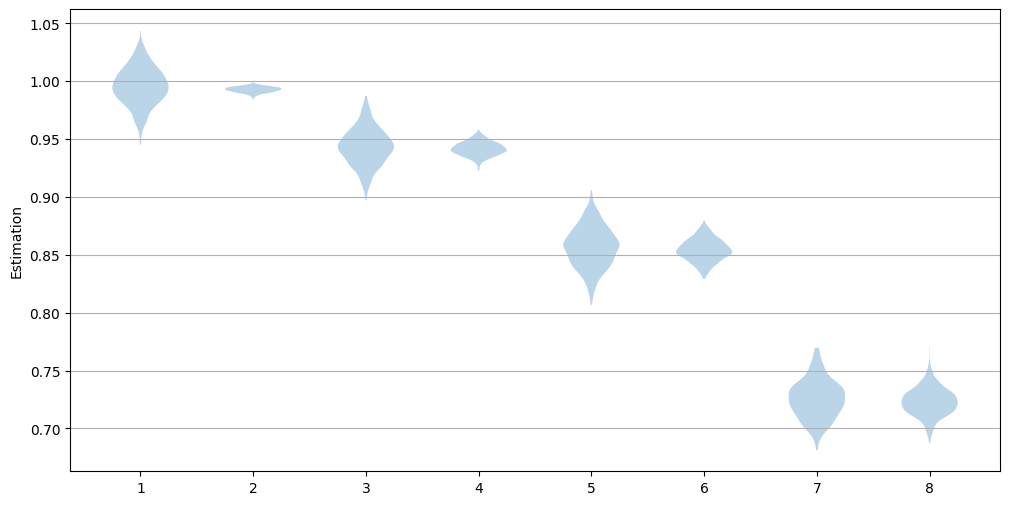

In [146]:
# Data from 250506 100k 0.2pi

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# generate some random test data

all_data = []

for eps in eps_list:
    all_data.append(cs_res[eps])
    all_data.append(rm2_res[eps])


# plot violin plot
axs.violinplot(all_data,showextrema=False)

# axs.set_title('1-param 3-qubit GHZ, Nu=20k, Ns=10k, Batch=10')

# axs.legend()
axs.set_ylabel('Estimation')

# # plot box plot
# axs.boxplot(all_data)
# axs.set_title('Box plot')
# # axs[0].axhline(y=fid_t_1, color='red', linestyle='--',label="Ground Truth")  


# adding horizontal grid lines
# for ax in axs:

# axs.axhline(y=0.0, color='red', linestyle='--',label="Ground Truth")  
axs.yaxis.grid(True)
# axs.set_xticks([y + 1 for y in range(len(all_data))],
#                 labels=[r'Shadow ($\epsilon=0.30$)',r'Shadow ($\epsilon=0.10$)', 'Shadow ($\epsilon=0.03$)', r'Bayesian ($\epsilon=0.30$)','Bayesian ($\epsilon=0.10$)', 'Bayesian ($\epsilon=0.03$)'])

plt.show()


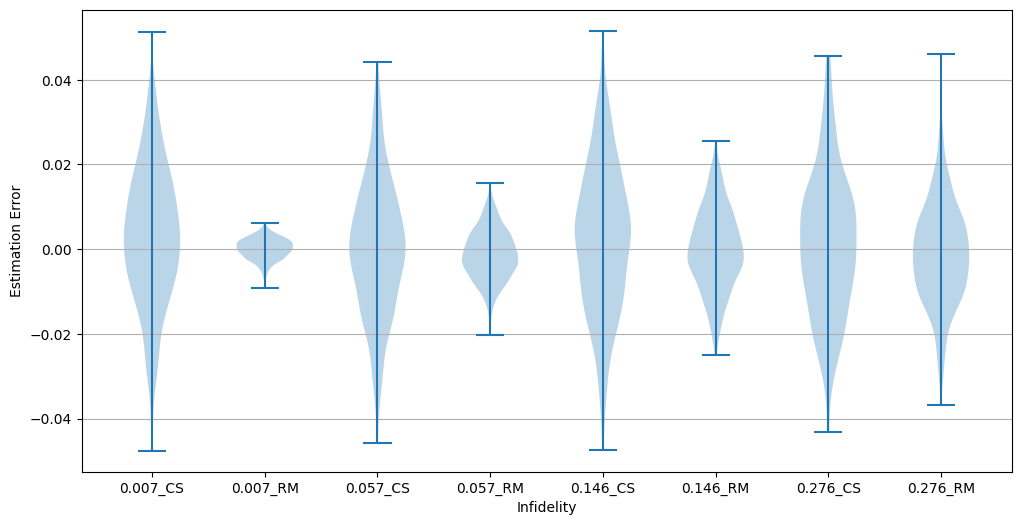

In [79]:
# Data from 250506 100k 0.2pi

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# generate some random test data

all_data = []
labels = []
for eps in eps_list:
    all_data.append(cs_res[eps] - f_ground_truth[eps])
    all_data.append(rm2_res[eps] - f_ground_truth[eps])
    labels += [f"{1-f_ground_truth[eps]:.{3}f}" + "_CS"]
    labels += [f"{1-f_ground_truth[eps]:.{3}f}" + "_RM"]

    


# plot violin plot
axs.violinplot(all_data,
                  showmeans=False,
                  showmedians=False)

# axs.set_title('1-param 3-qubit GHZ, Nu=20k, Ns=10k, Batch=10')

# axs.legend()
axs.set_ylabel('Estimation Error')
axs.set_xlabel('Infidelity')

# # plot box plot
# axs.boxplot(all_data)
# axs.set_title('Box plot')
# # axs[0].axhline(y=fid_t_1, color='red', linestyle='--',label="Ground Truth")  


# adding horizontal grid lines
# for ax in axs:

# axs.axhline(y=0.0, color='red', linestyle='--',label="Ground Truth")  
axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(len(all_data))],
                labels=labels)


plt.show()


## Boostrap

Additional boostrap for errorbar estimation

Compare theory with simulation

See data_plotting.ipynb for figures in paper

In [132]:
BS2 = 200
cs_sbs = {}
rm_sbs = {}
for eps in eps_list:
    print(eps)
    cs_sbs[eps] = []
    rm_sbs[eps] = []
    for _bs in range(BS2):
        ind_list = np.random.choice(BS,size=BS)
        cs_subsamp = [cs_res[eps][_k] for _k in ind_list]
        rm_subsamp = [rm2_res[eps][_k] for _k in ind_list]

        cs_sbs[eps].append(np.std(cs_subsamp))
        rm_sbs[eps].append(np.std(rm_subsamp))

    print("cs",np.mean(cs_sbs[eps]),np.std(cs_sbs[eps]))
    print("rm",np.mean(rm_sbs[eps]),np.std(rm_sbs[eps]))
    


0.05
cs 0.016222972796521205 0.00048317670766009034
rm 0.002456169140897216 8.413097791945429e-05
0.1
cs 0.015741255629037897 0.0005144196917400032
rm 0.005933538698008309 0.0001688404647389351
0.15
cs 0.01749138283655045 0.0005334552149342129
rm 0.009406491676474334 0.00027885086156433103
0.2
cs 0.016706022382197018 0.0005158013489477689
rm 0.011839223253012782 0.00040619652181414533


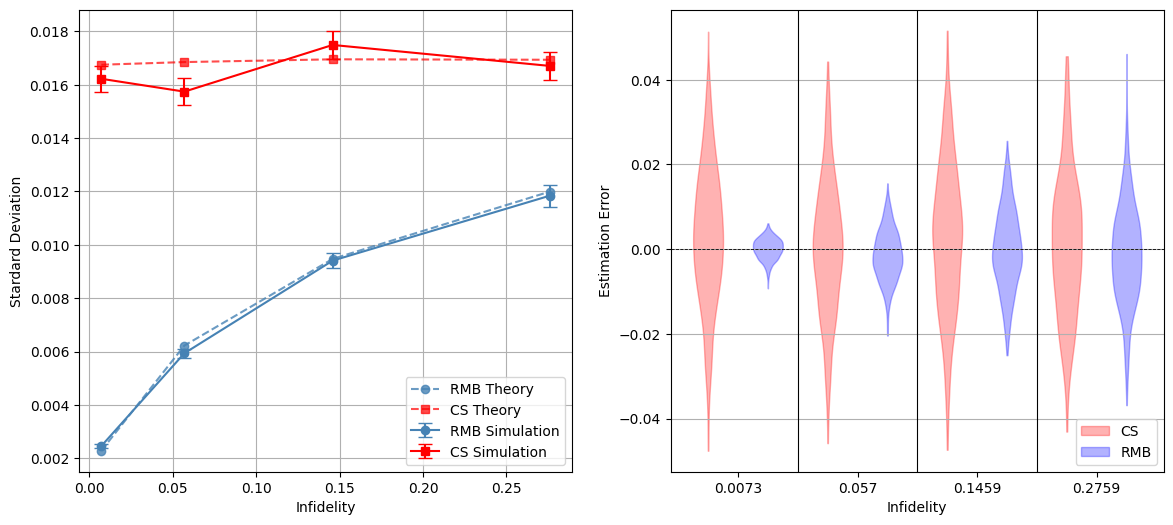

In [158]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

d = 1<<n

F = abs(sqrt((1-g_const*3)*(1-g_const*3-3*(array(eps_list)-offset))) + 3* sqrt(g_const*(g_const+array(eps_list)-offset)) )**2

all_data = []
labels = []
for eps in eps_list:
    all_data.append(cs_res[eps] - f_ground_truth[eps])
    all_data.append(rm2_res[eps] - f_ground_truth[eps])
    labels += [f"{1-f_ground_truth[eps]:.{3}f}" + "_CS"]
    labels += [f"{1-f_ground_truth[eps]:.{3}f}" + "_RM"]
# plot violin plot
parts = axs[1].violinplot(all_data,showextrema=False)
cnt = 0
for pc in parts['bodies']:
    if mod(cnt,2)==0:
        pc.set_color("red")
        if cnt<2:
            pc.set_label("CS")
    else:
        pc.set_color("blue")
        if cnt<2:
            pc.set_label("RMB")
    cnt+=1

myxtickslabel = []
for f in F:
    myxtickslabel.append("1-f = "+str(np.round(1-f,4)))
# print(myxtickslabel)
    
axs[1].set_xticks([1.5,3.5,5.5,7.5])
# axs[1].set_xticklabels(myxtickslabel)
axs[1].set_xticklabels(np.round(1-F,4))
axs[1].set_ylabel('Estimation Error')
axs[1].set_xlabel('Infidelity')
axs[1].yaxis.grid(True)

for x in [2.5,4.5,6.5]:
    axs[1].axvline(x=x, color='black', linewidth=0.8,linestyle='-')  
axs[1].axhline(y=0.0, color='black', linewidth=0.6,linestyle='--')  


axs[1].legend()



axs[0].plot(1-F,sqrt((4 *(8+1)/(8+2) * F*(1-F))/dpb),'--o',color='#4682B4',alpha=0.8,label="RMB Theory")
axs[0].plot(1-F,sqrt((2 *(8+1)*(1+2*F)/(8+2) - (1+F)**2)/dpb),'--s',color='red',alpha=0.7,label="CS Theory")

# axs[1].errorbar(1-F, [np.mean([(batch_res - f_ground_truth[eps])**2 for batch_res in rm2_res[eps]])  for eps in eps_list] ,[0.0]*len(F),'-o',label="RMB Sim")
# axs[1].errorbar(1-F, [np.mean([(batch_res - f_ground_truth[eps])**2 for batch_res in cs_res[eps]])  for eps in eps_list] ,[0.0]*len(F),'-s',label="CS Sim")

# axs[1].plot(1-F, [np.mean([(batch_res - f_ground_truth[eps])**2 for batch_res in rm2_res[eps]])  for eps in eps_list] ,'-o',label="RMB Sim")
# axs[1].plot(1-F, [np.mean([(batch_res - f_ground_truth[eps])**2 for batch_res in cs_res[eps]])  for eps in eps_list] ,'-s',label="CS Sim")


axs[0].errorbar(x = 1-F, y = [np.mean(rm_sbs[eps]) for eps in eps_list], yerr = [(np.std(rm_sbs[eps])) for eps in eps_list]  ,marker='o' ,capsize=5 ,color='#4682B4', label="RMB Simulation")

axs[0].errorbar(x = 1-F, y = [np.mean(cs_sbs[eps]) for eps in eps_list], yerr = [(np.std(cs_sbs[eps])) for eps in eps_list]  ,marker='s', capsize=5, color = 'red',label="CS Simulation")
# axs[0].errorbar(1-F, [np.var(cs_res[eps])  for eps in eps_list] , , '-s',label="CS Sim")
# axs[0].plot(1-F, [np.var(rm2_res[eps])  for eps in eps_list] , '-o',label="RMB Sim")
# axs[0].plot(1-F, [np.var(cs_res[eps])  for eps in eps_list] , '-s',label="CS Sim")


axs[0].set_xlabel(r"Infidelity")
axs[0].set_ylabel(r"Stardard Deviation")
axs[0].legend()
axs[0].grid()